<a href="https://colab.research.google.com/github/AlekseyBuzmakov/2023-TextAI/blob/main/2023_TextAI_Transformers_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Курс TextAI

# [Материалы](https://bit.ly/2023-TextAI)

# [GitHUB](https://github.com/AlekseyBuzmakov/2023-TextAI)

[Hugging face fine-tune example](https://huggingface.co/docs/transformers/training)

In [1]:
# МЕНЯ ВСТАВИТЬ В САМОЕ НАЧАЛО ЛЮБОГО JupyterNotebook,
#   А ПРИ ПОВТОРНОЕ РАБОТЕ ВСЕГДА ЗАПУСКАТЬ!

# Тут имя папки, в которую все сохраняется.
#  Менять это имя можно.
#  На Google Drive должно быть та же папка
#  Регистр (ЗАГЛАВНЫЕ или строчные буквы) важен!
# FOLDER = "2023-TextAI"

# PATH = "drive/MyDrive/" + FOLDER + "/"

# from google.colab import drive

# drive.mount("/content/drive")

# import os

# os.makedirs(PATH, exist_ok=True)

# import sys

# sys.path.append(PATH)

In [2]:
# Скачиваем данные
!gdown 1W7D3aD8h6CzlRh0FObkeetQBdp0n1do7

Downloading...
From: https://drive.google.com/uc?id=1W7D3aD8h6CzlRh0FObkeetQBdp0n1do7
To: /content/all_games.csv
100% 12.1M/12.1M [00:00<00:00, 63.2MB/s]


In [3]:
!pip install transformers
!pip install accelerate
!pip install evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 28.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 44.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 518.9/518.9 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.6 MB/s eta 0:00:00


In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re

import nltk
from tqdm.autonotebook import tqdm

import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn, optim
from transformers import AutoModelForSequenceClassification, BertTokenizerFast, TrainingArguments, Trainer, AutoConfig, AutoTokenizer

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import f1_score, accuracy_score

tqdm.pandas()  # для progress_apply
nltk.download('punkt')
sentence_tokenizer = nltk.data.load("tokenizers/punkt/russian.pickle")

np.random.seed(42)

<ipython-input-4-9af4e78e278c>:8: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [5]:
MODEL_NAME = "DeepPavlov/rubert-base-cased"

In [6]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

In [7]:
data = pd.read_csv("all_games.csv")
data.head()

,name,platform,release_date,summary,meta_score,user_review
0,The Legend of Zelda: Ocarina of Time,Nintendo 64,"November 23, 1998","As a young boy, Link is tricked by Ganondorf, ...",99,9.1
1,Tony Hawk's Pro Skater 2,PlayStation,"September 20, 2000",As most major publishers' development efforts ...,98,7.4
2,Grand Theft Auto IV,PlayStation 3,"April 29, 2008",[Metacritic's 2008 PS3 Game of the Year; Also ...,98,7.7
3,SoulCalibur,Dreamcast,"September 8, 1999","This is a tale of souls and swords, transcendi...",98,8.4
4,Grand Theft Auto IV,Xbox 360,"April 29, 2008",[Metacritic's 2008 Xbox 360 Game of the Year; ...,98,7.9


In [8]:
data.isna().sum(), data.shape

(name              0
 platform          0
 release_date      0
 summary         114
 meta_score        0
 user_review       0
 dtype: int64,
 (18800, 6))

In [9]:
data = data.dropna()
data = data.reset_index()
data.isna().sum(), data.shape

(index           0
 name            0
 platform        0
 release_date    0
 summary         0
 meta_score      0
 user_review     0
 dtype: int64,
 (18686, 7))

# Работа с моделями

In [10]:
class MyTextDataset(Dataset):
    def __init__(self, values, tokenizer, labels):
        self.labels = torch.tensor(labels, dtype=torch.float)
        self.text = tokenizer(values, max_length=512, padding="max_length", truncation=True, return_tensors="pt")

    def __len__(self):
        return len(self.labels) - 1

    def __getitem__(self, idx):
        text = self.text["input_ids"][idx]
        attention = self.text["attention_mask"][idx]
        token_type_ids = self.text["token_type_ids"][idx]

        return {"input_ids": text, "attention_mask": attention, "token_type_ids":token_type_ids, "labels": self.labels[idx]}

In [11]:
def freeze_model(model, start: int = 10, end: int = 12):
    for p in model.bert.parameters():
        p.requires_grad=False

    for layer in range(start, end):
        for p in model.bert.encoder.layer[layer].parameters():
            p.requires_grad=True

## Transformers

In [12]:
config = AutoConfig.from_pretrained(MODEL_NAME, num_labels=1)  # SET num_labels!!!
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, config=config)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
freeze_model(model, 11, 12)

In [14]:
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12

In [15]:
tokenize_res = tokenizer("Мама мыла раму", max_length=512, padding="max_length", truncation=True, return_tensors="pt")
model(**tokenize_res)

SequenceClassifierOutput(loss=None, logits=tensor([[-0.0054]], grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)

In [16]:
dataset = MyTextDataset(data["summary"].tolist(), tokenizer, data["meta_score"].tolist())
dataset[100]

{'input_ids': tensor([   101,  11394,  14780,  25419,    128,  17300,  51195,  32084,   3772,
            118,    268,  11504,  67510,  14932,    239,  13310,  13532,   6931,
          30006,  10815,  12527,  10837,  11124,    128,  13540,  10813,  14447,
          44816,    239,  10626,  11931, 114954,    241,    232,  10740,  11149,
          12535,  14011,  11878,  10037,  10815,  12527,  10837,  13838,  10626,
          10618,  35104,  15854,  10728,  10623,  10637,  21446,  10731,  10728,
            232,  11263,  15759,  10037,  27490,    267,  17992,   7168,  11300,
          17103,    269,  45285,  19335,  33633,  10618,  11737,  14608,    132,
          12211,  20954,  28432,  14032,  10978,    255,  10636,    232,  14107,
          18965,  10968,  23944,  10037,  11569,  14347,  17493,  12371,  10888,
           7729,  10700,  38104,  34891,  21520, 101498,  10854,  13145,  10626,
          11931,  13225,  28523,   4676,  11796,  10852,  11707,  11867,  12463,
          94915

In [17]:
model(**dataset[[100]])

SequenceClassifierOutput(loss=tensor(8861.2393, grad_fn=<MseLossBackward0>), logits=tensor([[-0.1342]], grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)

# Transformers trainer

In [18]:
train_sentences, test_sentences = train_test_split(data, test_size=0.2)
train_sentences.shape, test_sentences.shape

((14948, 7), (3738, 7))

In [19]:
train_ds = MyTextDataset(train_sentences["summary"].tolist(), tokenizer, train_sentences["meta_score"].tolist())
test_ds = MyTextDataset(test_sentences["summary"].tolist(), tokenizer, test_sentences["meta_score"].tolist())

In [20]:
import evaluate

metric = evaluate.load("mae")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    return metric.compute(predictions=logits, references=labels)

batch_size = 32

training_args = TrainingArguments(
    "trained",
    evaluation_strategy="epoch",
    num_train_epochs = 3,
    per_device_train_batch_size = batch_size,
    per_device_eval_batch_size = batch_size,
    logging_steps=10,
)

In [21]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    compute_metrics=compute_metrics
)

In [22]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Mae
1,3624.382800,3497.768799,57.856607
2,2677.827300,2711.025146,50.602841
3,2597.691400,2468.233398,48.145432


TrainOutput(global_step=1404, training_loss=3268.9373608885326, metrics={'train_runtime': 2219.3127, 'train_samples_per_second': 20.205, 'train_steps_per_second': 0.633, 'total_flos': 1.1798056902454272e+16, 'train_loss': 3268.9373608885326, 'epoch': 3.0})

In [23]:
trainer.save_model("model-3epochs")

In [24]:
def plot_loss(history):
    training_loss = []
    for item in history:
        if "loss" not in item.keys():
            continue
        training_loss.append(item["loss"])
    plt.plot(training_loss)

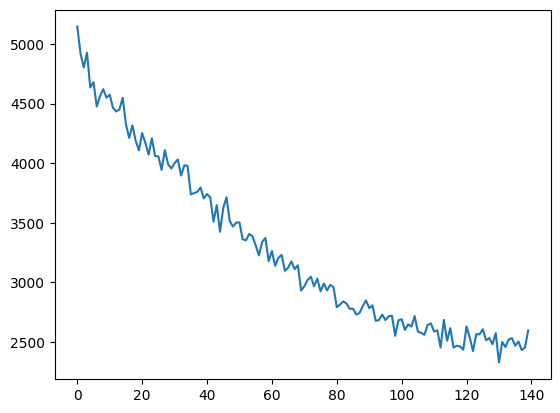

In [25]:
plot_loss(trainer.state.log_history)

# Load

In [30]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained("model-3epochs")

In [32]:
tokenize_res = tokenizer("Мама мыла раму", max_length=512, padding="max_length", truncation=True, return_tensors="pt")
model(**tokenize_res)

SequenceClassifierOutput(loss=None, logits=tensor([[3.2867]], grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)

In [34]:
model(**tokenize_res).logits[0]

tensor([3.2867], grad_fn=<SelectBackward0>)

In [31]:
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12